### Main Script

In [1]:
import tensorflow as tf
import sys
from roboflow import Roboflow
from dfp.net import *
from dfp.data import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from argparse import Namespace
import os
import gc
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#sys.path.append(root + '\\TF2DeepFloorplan\\dfp\\utils')
from dfp.utils.rgb_ind_convertor import *
from dfp.utils.util import *
#from dfp.utils.legend import *
from dfp.deploy import *
print(tf.test.is_gpu_available())
import cv2 as cv
from PIL import Image

<module 'dfp._paths' from 'C:\\Users\\Admin\\Documents\\Jupyter_Scripts\\Deepfloorplan\\dfp\\_paths.py'>
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [27]:
def door_detection(img_path = './30939153.jpg'):
    doors = []
    img = cv2.imread(img_path)
    img = resize_to_square(img)
    temp = img_path.split('.')[-2] + '_temp.jpg'
    cv2.imwrite(temp,img )
    img_doors = np.zeros((img.shape[0],img.shape[1]))
    try:
        
        #detection
        rf = Roboflow(api_key="7W0fIqzuiJGplpXG0C5L")

        workspace = rf.workspace("kuanghiu")

        project = workspace.project("door-yvyzd")

        version = project.version(1)

        model = version.model

        prediction = model.predict(temp)

        json_file = prediction.json()
        #save results
        padding = 2
        for it in json_file['predictions']:
            door = np.zeros((img.shape[0],img.shape[1]))
            door[int(it['y'] - it['height']/2)-padding : int(it['y']+it['height']/2)+ padding, int(it['x']- it['width']/2) - padding : int(it['x'] + it['width']/2) + padding] = 255
            doors.append(door)
        print('Detect door sussecful. Have {} doors in plan'.format(len(doors)))
        os.remove(temp)
        for i in range(len(doors)):
            img_doors = img_doors + doors[i]
    except:
        print('Something wrong. We dont find any door in plan')
    return img_doors

In [3]:
def resize_to_square(im, color = [0]):
    
    img_size = max(im.shape)
    old_size = im.shape
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])    
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    #color = [0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv.BORDER_CONSTANT,value=color)
    return new_im #cv.resize(new_im,(256,256), interpolation = cv.INTER_NEAREST)

In [4]:
def deepfloorplan(img_path):
    args = Namespace(image = img_path ,
            weight='model_wall/store/G',loadmethod='log',
            postprocess=True,colorize=True,
            save=None)
    result = main(args)
    img = result.astype(np.uint8)
    return resize_to_square(img)

In [49]:
img = deepfloorplan('test/input/mb10.jpg')

(576, 587, 3) (576, 587, 3)


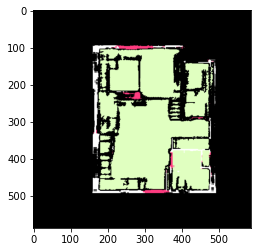

In [50]:
plt.imshow(img)

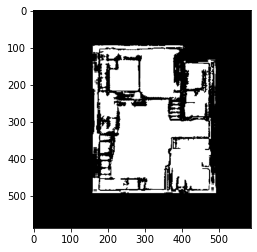

In [51]:
mask_inside = np.float32(np.where(img != 0, 255., 0.))
mask_inside = cv2.cvtColor(mask_inside, cv2.COLOR_BGR2GRAY)
mask_inside = mask_inside.astype(np.uint8)
plt.imshow(mask_inside, cmap = 'gray')


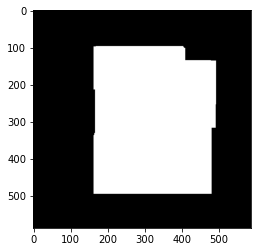

In [52]:

def preprocess_mask(mask_inside):
    binr = cv2.threshold(mask_inside, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    # define the kernel
    kernel = np.ones((100, 100), np.uint8)

    # opening the image
    closing = cv2.morphologyEx(binr, cv2.MORPH_CLOSE, kernel, iterations=1)
    # opening the image
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN,kernel, iterations=1)

    return opening
opening = preprocess_mask(mask_inside)
plt.imshow(opening, cmap = 'gray')

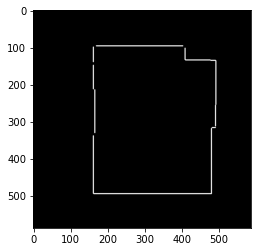

In [53]:
corner_img = np.float32(np.where(img != 0, 0., 0.))

def detect_Line(gray_img):
    corner_img = np.float32(np.where(gray_img != 0, 0., 0.))
    edges = cv2.Canny(gray_img, 100, 200)

    minLineLength = 5 # Changing this to 100 does nothing.
    maxLineGap = 5
    threshold = 10
    lines = cv2.HoughLinesP(edges,1,np.pi/180,threshold,minLineLength,maxLineGap)
    list_lines = []
    for l in lines:
        for x1,y1,x2,y2 in l:
            list_lines.append([x1,y1,x2,y2])
            cv2.line(corner_img,(x1,y1),(x2,y2),(255,255,255), 2)
    return corner_img, list_lines

corner_img, _ = detect_Line(opening)
plt.imshow(corner_img, cmap = 'gray')

In [54]:
def detect_hor_ver_line(corner_img):
    img = np.zeros_like(corner_img)

    v_kernel = np.ones((11,3),np.uint8)
    h_kernel = np.ones((3,11),np.uint8)
    
    #detect raw vertical line
    try:
        verticalLines = cv2.erode(corner_img, v_kernel, iterations = 1)
        img = cv2.cvtColor(verticalLines, cv2.COLOR_GRAY2BGR)
        verticalLines = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        v_lines, list_v_lines = detect_Line(verticalLines.astype(np.uint8))
        #vectorizer vertical line
        lines = list_v_lines
        for i in range(len(lines)):
            for j in range(i,len(lines)):
                if abs(lines[i][0] - lines[j][0]) <= 15:
                    lines[j][0] = lines[i][0]
                    lines[j][2] = lines[i][0]
                    if abs(lines[i][1] - lines[j][1]) <= 20:
                        lines[j][1] = lines[i][1]
                    elif abs(lines[i][1] - lines[j][3]) <= 20:
                        lines[j][3] = lines[i][1]
                    elif abs(lines[i][3] - lines[j][1]) <= 20:
                        lines[j][1] = lines[i][3]
    except:
        pass
                    
    #detect raw horizontal line
    try:
        horizontalLines = cv2.erode(corner_img, h_kernel, iterations = 1)
        img = cv2.cvtColor(horizontalLines, cv2.COLOR_GRAY2BGR)
        horizontalLines = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        h_lines, list_h_lines = detect_Line(horizontalLines.astype(np.uint8))
        #vectorizer horizontal line
        lines = list_h_lines
        for i in range(len(lines)):
            for j in range(i,len(lines)):
                if abs(lines[i][1] - lines[j][1]) <= 15:
                    lines[j][1] = lines[i][1]
                    lines[j][3] = lines[i][1]
                    if abs(lines[i][0] - lines[j][2]) <= 20:
                        lines[j][2] = lines[i][0]
                    elif abs(lines[i][0] - lines[j][0]) <= 20:
                        lines[j][0] = lines[i][0]
                    elif abs(lines[i][2] - lines[j][0]) <= 20:
                        lines[j][0] = lines[i][2]
    except:
        pass
    
    #remove lines same as a point and swap end start point 
    try:
        for i in range(len(list_v_lines)):
            if list_v_lines[i][1] > list_v_lines[i][3]:
                start = list_v_lines[i][3]
                end = list_v_lines[i][1]
                list_v_lines[i][1] = start
                list_v_lines[i][3] = end
    except:
        pass
    try:
        for i in range(len(list_h_lines)):
            if list_h_lines[i][0] > list_h_lines[i][2]:
                start = list_h_lines[i][2]
                end = list_h_lines[i][0]
                list_h_lines[i][0] = start
                list_h_lines[i][2] = end
    except:
        pass
    
    try:
        list_v = []
        for i in range(len(list_v_lines)):
            if list_v_lines[i][0] != list_v_lines[i][2] or list_v_lines[i][1] != list_v_lines[i][3]:
                list_v.append(list_v_lines[i])
    except:
        pass
    
    try:
        list_h = []
        for i in range(len(list_h_lines)):
            if list_h_lines[i][0] != list_h_lines[i][2] or list_h_lines[i][1] != list_h_lines[i][3]:
                list_h.append(list_h_lines[i])
    except:
        pass
    
    v_lines = []
    [v_lines.append(x) for x in list_v if x not in v_lines]
    h_lines = []
    [h_lines.append(x) for x in list_h if x not in h_lines]
    return v_lines, h_lines
list_v_lines, list_h_lines = detect_hor_ver_line(corner_img)

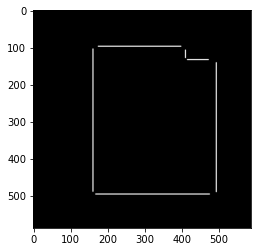

In [55]:
result  = np.zeros_like(corner_img)
for l in list_v_lines:
    cv2.line(result,(l[0],l[1]),(l[2],l[3]),(255,255,255), 2)
for l in list_h_lines:
    cv2.line(result,(l[0],l[1]),(l[2],l[3]),(255,255,255), 2)

plt.imshow(result, cmap = 'gray')

In [56]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return 9999999999, 9999999999

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


In [57]:
def extend_vertical_line(list_v_lines, list_h_lines):
    v_lines = list_v_lines
    intersections = {}
    for v in range(len(list_v_lines)):
        for h in range(len(list_h_lines)):
            x, y = line_intersection(([list_v_lines[v][0],list_v_lines[v][1]],[list_v_lines[v][2],list_v_lines[v][3]]),
                                            ([list_h_lines[h][0],list_h_lines[h][1]],[list_h_lines[h][2],list_h_lines[h][3]]))
            if y <= min(list_v_lines[v][1], list_v_lines[v][3]) or y >= max(list_v_lines[v][1], list_v_lines[v][3]):
                dis_v_start = list_v_lines[v][1] - y
                dis_v_end =  y - list_v_lines[v][3]

                intersections[(v, h)] = [x, y, dis_v_start, dis_v_end]          
    for v in range(len(list_v_lines)):
        start_dis = []
        end_dis = []
        for point in intersections.keys():
            if point[0] == v:
                if intersections[point][2] >= 0:
                    start_dis.append(intersections[point][2])
                if intersections[point][3] >= 0:
                    end_dis.append(intersections[point][3])
        try:
            min_distance_start = min(start_dis)
        except:
            min_distance_start = 0
        try:
            min_distance_end = min(end_dis)
        except:
            min_distance_end = 0
            
        for point in intersections.keys():
            if point[0] == v and intersections[point][2] == min_distance_start:
                x_start = intersections[point][0]
                y_start = intersections[point][1]
            if point[0] == v and intersections[point][3] == min_distance_end:
                x_end = intersections[point][0]
                y_end = intersections[point][1]
        try:        
            v_lines[v] = [int(x_start), int(y_start), int(x_end), int(y_end)]
        except:
            pass
    
    res = []
    [res.append(x) for x in v_lines if x not in res]
    
    return res

In [58]:
def extend_horizontal_line(list_h_lines, list_v_lines):
    h_lines = list_h_lines
    intersections = {}
    for h in range(len(list_h_lines)):
        for v in range(len(list_v_lines)):
            x, y = line_intersection(([list_v_lines[v][0],list_v_lines[v][1]],[list_v_lines[v][2],list_v_lines[v][3]]),
                                            ([list_h_lines[h][0],list_h_lines[h][1]],[list_h_lines[h][2],list_h_lines[h][3]]))
            if x <= min(list_h_lines[h][0], list_h_lines[h][2]) or x >= max(list_h_lines[h][0], list_h_lines[h][2]):
                dis_h_start = list_h_lines[h][0] - x
                dis_h_end =  x - list_h_lines[h][2]

                intersections[(h, v)] = [x, y, dis_h_start, dis_h_end]
                
    for h in range(len(list_h_lines)):
        start_dis = []
        end_dis = []
        for point in intersections.keys():
            if point[0] == h:
                if intersections[point][2] >= 0:
                    start_dis.append(intersections[point][2])
                if intersections[point][3] >= 0:
                    end_dis.append(intersections[point][3])
        try:
            min_distance_start = min(start_dis)
        except:
            min_distance_start = 0
        try:
            min_distance_end = min(end_dis)
        except:
            min_distance_end = 0
        for point in intersections.keys():
            if point[0] == h and intersections[point][2] == min_distance_start:
                x_start = intersections[point][0]
                y_start = intersections[point][1]
            if point[0] == h and intersections[point][3] == min_distance_end:
                x_end = intersections[point][0]
                y_end = intersections[point][1]
        try:
            h_lines[h] = [int(x_start), int(y_start), int(x_end), int(y_end)]
        except:
            pass
    
    
    res = []
    [res.append(x) for x in h_lines if x not in res]
    return res

In [59]:
v_lines = extend_vertical_line(list_v_lines, list_h_lines)
h_lines = extend_horizontal_line(list_h_lines, v_lines)


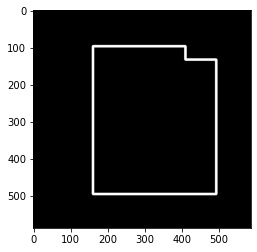

In [60]:
result  = np.zeros_like(corner_img)
for l in v_lines:
    cv2.line(result,(l[0],l[1]),(l[2],l[3]),(255,255,255), 5)
for l in h_lines:
    cv2.line(result,(l[0],l[1]),(l[2],l[3]),(255,255,255), 5)

plt.imshow(result, cmap = 'gray')

In [80]:
def preprocces_data(img_path, length = 10):
    
    #use cnn to detect plan space
    img = deepfloorplan(img_path)
    
    #convert mask_inside to 255, 0 image
    mask_inside = np.float32(np.where(img != 0, 255., 0.))
    mask_inside = cv2.cvtColor(mask_inside, cv2.COLOR_BGR2GRAY)
    mask_inside = mask_inside.astype(np.uint8)
    
    #remove noise pixel
    opening = preprocess_mask(mask_inside)
    
    #use Canny detect boundary mask
    corner_img, _ = detect_Line(opening)

    #cluster vertical and horizontal line
    list_v_lines, list_h_lines = detect_hor_ver_line(corner_img)
    
    #extend line
    v_lines = extend_vertical_line(list_v_lines, list_h_lines)
    h_lines = extend_horizontal_line(list_h_lines, v_lines)
    
    walls  = np.zeros_like(corner_img)
    for l in v_lines:
        cv2.line(walls,(l[0],l[1]),(l[2],l[3]),(127,127,127), 7)
    for l in h_lines:
        cv2.line(walls,(l[0],l[1]),(l[2],l[3]),(127,127,127), 7)
        
    
    #detect main door
    doors = door_detection(img_path)
    doors = np.float32(np.where(doors != 0, 127., 0.))
    
    main_door = cv2.bitwise_and(doors, walls, mask = None)
    _, main_door_point = detect_Line(main_door.astype(np.uint8))
    door = np.zeros_like(main_door)
    l = main_door_point[0]
    cv2.line(door,(l[0],l[1]),(l[2],l[3]),(127,127,127), 15)
    main_door = cv2.bitwise_and(walls, door, mask = None)
    main_door = np.where(main_door == 127, 128, main_door)
    #find witdh's house
    p = []
    for l in h_lines:
        p.append(l[0])
        p.append(l[2])
    
    
    boundary  = walls + main_door
    
    w_floor = abs(max(p) - min(p))
    ts = 18*w_floor
    pixel_width = round(ts/length)
    if pixel_width > walls.shape[0]:
        padding = pixel_width - walls.shape[0]
        boundary = cv2.copyMakeBorder(boundary, padding, padding, padding, padding, cv.BORDER_CONSTANT,value=[0])
        opening = cv2.copyMakeBorder(opening, padding, padding, padding, padding, cv.BORDER_CONSTANT,value=[0])
    elif pixel_width < walls.shape[0]:
        padding = int((walls.shape[0] - pixel_width)/2)
        boundary = boundary[padding:walls.shape[0] - padding,padding : walls.shape[0] - padding]
        opening = opening[padding:walls.shape[0] - padding,padding : walls.shape[0] - padding]
     
    c0 = cv.resize(boundary,(256,256), interpolation = cv.INTER_NEAREST)
    c1 = np.zeros_like(c0)
    c2 = c1
    inside  = opening
    c3 = cv.resize(inside,(256,256), interpolation = cv.INTER_NEAREST)
    
    img = np.stack([c0,c1,c2,c3], axis=-1).astype(np.uint8)
    result = Image.fromarray(img)

    result.save(img_path.split('.')[0] +".png")
    print(f'solved file: {img_path}')
    #plt.imshow(result, cmap = 'gray')
    return result

In [84]:
result = preprocces_data(img_path = 'test/input/mb7.jpg', length = 12)
    

(576, 1042, 3) (576, 1042, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 7 doors in plan
solved file: test/input/mb7.jpg


In [86]:
import os
root = 'C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/'
for name in os.listdir(root):
    try:
        result = preprocces_data(root + name, length = 12)
    except:
        continue

(606, 676, 3) (606, 676, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 6 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/3f45a5e7f3c0a6c438dd6ca4fbbad40a.jpg


(614, 686, 3) (614, 686, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 4 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/mb1.jpg


(576, 587, 3) (576, 587, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 3 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/mb10.jpg


(662, 738, 3) (662, 738, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 3 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/mb2.jpg


(503, 697, 3) (503, 697, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 3 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/mb5.JPG


(498, 610, 3) (498, 610, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 5 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/mb6.JPG


(576, 1042, 3) (576, 1042, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 7 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/mb7.jpg


(1158, 760, 3) (1158, 760, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 7 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/mb8.jpg


(576, 809, 3) (576, 809, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 6 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/mb9.jpg


(598, 732, 3) (598, 732, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 4 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/Riverside2.jpg


(540, 640, 3) (540, 640, 3)
loading Roboflow workspace...
loading Roboflow project...
Detect door sussecful. Have 6 doors in plan
solved file: C:/Users/Admin/Documents/Jupyter_Scripts/Deepfloorplan/test/input/Riverside4.jpg


In [41]:
def detect_wall(img_path):
    args = Namespace(image = img_path ,
            weight='model_wall/store/G',loadmethod='log',
            postprocess=True,colorize=True,
            save=None)
    model,img,shp = init(args)
    logits_cw,logits_r = predict(model,img,shp)
    logits_cw = tf.image.resize(logits_cw,shp[:2])
    r = convert_one_hot_to_image(logits_r)[0].numpy()
    result = convert_one_hot_to_image(logits_cw)[0].numpy()
    plt.imshow(r)
    return resize_to_square(r)

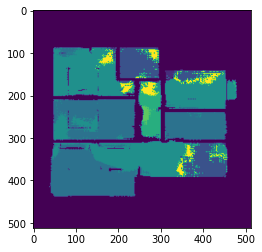

In [42]:
walls = detect_wall(path)

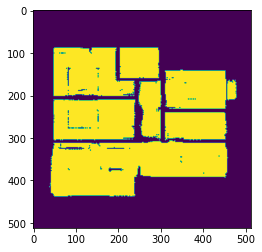

In [43]:
walls =np.where(walls != 0, 255, 0)
plt.imshow(walls)

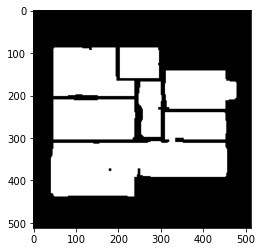

In [46]:
def preprocess_wall(mask_inside):
    binr = cv2.threshold(mask_inside, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    # define the kernel
    kernel = np.ones((5, 5), np.uint8)

    # opening the image
    closing = cv2.morphologyEx(binr, cv2.MORPH_CLOSE, kernel, iterations=1)
    # opening the image
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN,kernel, iterations=3)

    return opening
w = preprocess_wall(walls.astype(np.uint8))
plt.imshow(w, cmap = 'gray')